In [1130]:
import gzip
from collections import defaultdict
import sklearn
from sklearn import linear_model
from sklearn import ensemble
import string
import re
import datetime, time
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as md
import math
import pandas as pd

In [1090]:
#####
# Setup
#####

In [1091]:
def readCSV(path):
    f = open(path, 'rt')
    f.readline()

    for l in f:
        
        if l.startswith("timestamp"): 
            continue

        try: 
            timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid,rowNumber,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education = re.split(r',(?![ ])', l)

        except:
            continue

        yield timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid,rowNumber,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education

In [1092]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [1093]:
#####
# Parse data from dataset
#####

In [1094]:
# id , unixtime, company, level, title, total_comp, city, state, experience, tenure, tag, 
# salary, stock, bonus, city_id, dma_id, ms_deg, bs_deg, phd_deg, hs, college
def parseSalaryRaw(salaryRaw):
    salaryAllData = []

    for entry in salaryRaw:

        date, clocktime = entry[0].split(' ')
        date = date.split('/')
        clocktime = clocktime.split(':')
        timestamp = datetime.datetime(int(date[2]), int(date[0]), int(date[1]), int(clocktime[0]), int(clocktime[1]), int(clocktime[2]))
        timestamp = int(time.mktime(timestamp.timetuple()))


        company = entry[1]
        level = entry[2]
        title = entry[3]

        total_comp = int(float(entry[4]))

        location = entry[5]
        if location.count(',') == 2:
            city, state, country = location.strip('"').split(', ')
        elif location.count(',') == 1:
            city, state = location.strip('"').split(', ')
            country = 'USA'

        experience = entry[6]
        tenure = entry[7]

        tag = entry[8]

        salary = int(float(entry[9]))
        if salary == 0:
            continue

        stock = int(float(entry[10]))
        bonus = int(float(entry[11]))

        g = entry[12]
        gender = -1
        if g == 'Female':
            gender = 0
        elif g == 'Male':
            gender = 1
        elif g == 'Other':
            gender = 2

        city_id = int(entry[14])

        try: 
            dma_id = int(entry[15])
        except:
            dma_id = -1

        id = int(entry[16])

        ms_deg = int(entry[17])
        bs_deg = int(entry[18])
        phd_deg = int(entry[18])
        hs = int(entry[19])
        college = int(entry[20])

        r = entry[27]
        race = -1
        if r == 'Asian':
            race = 0
        elif r == 'Black':
            race = 1
        elif r == 'Hispanic':
            race = 2
        elif r == 'Two Or More':
            race = 3
        elif r == 'White':
            race = 4


        salaryAllData.append({
            'id': id,
            'timestamp': timestamp,
            'company': company,
            'level': level,
            'title': title,
            'total_comp': total_comp,
            'city': city,
            'state': state,
            'country': country,
            'experience': experience,
            'tenure': tenure,
            'tag': tag,
            'salary': salary,
            'stock': stock,
            'bonus': bonus,
            'gender': gender,
            'city_id': city_id,
            'dma_id': dma_id,
            'ms_deg': ms_deg,
            'bs_deg': bs_deg,
            'phd_deg': phd_deg,
            'hs': hs,
            'college': college,
            'race': race,
        })
    return salaryAllData


In [1095]:
# Reparse data from CSV so we don't mess up above data
salaryRaw = []
for l in readCSV("Levels_Fyi_Salary_Data.csv"):
    salaryRaw.append(l)

salaryAllData = parseSalaryRaw(salaryRaw)
salaryAllData[0]['id']

1

In [1096]:
# Parse raw data
salaryAllData = parseSalaryRaw(salaryRaw)

In [1097]:
# EDA

In [1098]:
title = [d['title'] for d in salaryAllData]
salary = [d['salary'] for d in salaryAllData]
city = [d['city'] for d in salaryAllData]
experience = [d['experience'] for d in salaryAllData]
df = pd.DataFrame({'title' : title, 'salary' : salary, 'city' : city, 'experience' : experience})

<AxesSubplot:title={'center':'Average Salary by Title'}, xlabel='Title', ylabel='Average Salary'>

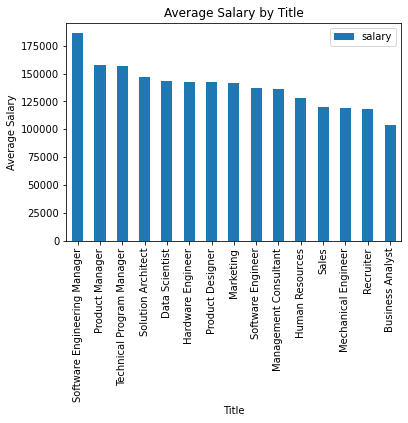

In [1099]:
df.groupby(['title']).agg({'salary':'mean'}).sort_values(by = 'salary', ascending=False)\
.plot(kind = 'bar',title = 'Average Salary by Title', xlabel = 'Title',ylabel = 'Average Salary')

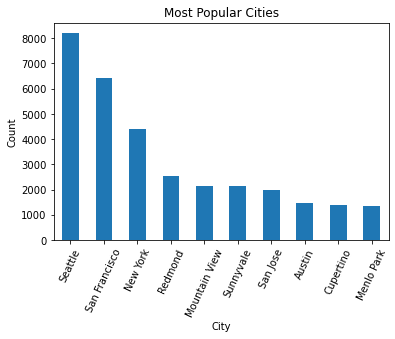

In [1100]:
df["city"].value_counts().iloc[:10].plot(kind="bar", title = 'Most Popular Cities', xlabel = 'City', \
ylabel = 'Count', rot = 65)
plt.show()

In [1101]:
#####
# Training, Validation, and Test sets
#####

# shuffle data
shuffledAllData = sklearn.utils.shuffle(salaryAllData)
shuffledAllData[0]['id']

# create 80 / 10 / 10 : Train / Validation / Test sets
X = shuffledAllData
y = [d['salary'] for d in shuffledAllData]

X_train, X_temp, y_train, y_temp = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
X_valid, X_test, y_valid, y_test = sklearn.model_selection.train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

# Validate that sets were created with propper sizes
print(str(len(X_train)) + ", " + str(len(y_train)))
print(str(len(X_valid)) + ", " + str(len(y_valid)))
print(str(len(X_test)) + ", " + str(len(y_test)))

# Validate all ids are different
print(str(X_train[0]['id']) + ", " + str(X_valid[0]['id']) + ", " + str(X_test[0]['id']))

47996, 47996
6000, 6000
6000, 6000
74113, 30663, 62947


In [1102]:
#####
# Baselines
#   1. Predict average salary in dataset
#   2. Predict average salary for given Years of Experience
#####

In [1103]:
# Create some useful collections for these baseline

# create YOE to Average Map based on training data
# We create two dictionaries to track the total salary seen at each YOE
salByExpMap = defaultdict(int)

# And the number of salaries seen at that YOE
entriesByExpMap = defaultdict(int)

# For each entry increment the total sal and num entries at that YOE
# (This could be done with a running avg technique but that is too much work to code)
for x in X_train:
    exp, sal = float(x['experience']), float(x['salary'])
    exp = math.ceil(exp)
    
    total = 0
    numEntries = 0
    
    if salByExpMap[exp]:
        total = salByExpMap[exp]
    if entriesByExpMap[exp]:
        numEntries = entriesByExpMap[exp]
    
    total += sal
    numEntries += 1
    
    salByExpMap[exp] = total
    entriesByExpMap[exp] = numEntries
    

    
# Calculate averages by YOE as well as total avg
totalSal = 0
totalCount = 0

averageSalaryByYoeMap = defaultdict(int)
for exp in entriesByExpMap:
    avg = salByExpMap[exp] / entriesByExpMap[exp]
    averageSalaryByYoeMap[exp] = avg
    
    totalSal += salByExpMap[exp]
    totalCount += entriesByExpMap[exp]

avgSal = totalSal / totalCount

print("Average salary: " + str(avgSal))


def pred_baseline1(x):    
    return avgSal
    
def pred_baseline2(x):    
    exp = math.ceil(float(x['experience']))

    if averageSalaryByYoeMap[exp]:
        return averageSalaryByYoeMap[exp]
    else:
        return avgSal

Average salary: 141888.61228019002


In [1104]:
def baseline1():
    # Returns average salary in dataset
    y_b1 = []
    y_b1_pred = []
    
    avg_err = 0
    avg_percent_err = 0
    
    for d in X_valid:
        pred = pred_baseline1(d)
        actual = d['salary']
        
        y_b1_pred.append(pred)
        y_b1.append(actual)
        
        avg_err += abs(actual - pred)
        avg_percent_err += abs(100 * ((pred - actual) / actual))
        
    mse = MSE(y_b1_pred, y_b1)
    
    avg_err = avg_err / len(X_valid)
    avg_percent_err = avg_percent_err / len(X_valid)
    
    return mse, avg_err, avg_percent_err

In [1105]:
mse_b1, avg_err_b1, avg_percent_err_b1 = baseline1()
print(mse_b1)
print(avg_err_b1)
print(avg_percent_err_b1)

3526271532.2132955
39399.44407485346
46.178827403240476


In [1106]:
def baseline2():
    # Takes rounded YOE for each datapoint and predicts average salary for that YOE
    # If there are no entries for that YOE, predict overall average
    y_b1 = []
    y_b1_pred = []
    
    avg_err = 0
    avg_percent_err = 0
    
    for d in X_valid:
        pred = pred_baseline2(d)
        actual = d['salary']
        
        y_b1_pred.append(pred)
        y_b1.append(actual)
        
        avg_err += abs(actual - pred)
        avg_percent_err += abs(100 * ((pred - actual) / actual))
        
    mse = MSE(y_b1_pred, y_b1)
    
    avg_err = avg_err / len(X_valid)
    avg_percent_err = avg_percent_err / len(X_valid)
    
    return mse, avg_err, avg_percent_err

In [1107]:
mse_b2, avg_err_b2, avg_percent_err_b2 = baseline2()
print(mse_b2)
print(avg_err_b2)
print(avg_percent_err_b2)

2889818922.8275948
34296.64643263295
40.124616244553415


In [1108]:
#####
# Model
#####

In [1109]:
#####
# Provide a description of your model:
#      1. What model are you using
#      2. What information are you trying to incorporate into your model
#      3. How are you building your feature vector?
#      4. What interesting pieces of information did you learn? (i.e. most influential words, popular cities, etc)
#####

# Write description in comments here

In [1110]:
# Model code starts here

In [1111]:
def feat(d):
    exp = float(d['experience'])
    ten = float(d['tenure'])
    if d['hs'] == 1:
        edu = 12.0
    elif d['college'] == 1:
        edu = 14.0
    elif d['bs_deg'] == 1:
        edu = 16.0
    elif d['ms_deg'] == 1:
        edu = 18.0
    elif d['phd_deg'] == 1:
        edu = 21.0
    else:
        edu = 16.0
    return [1, exp, ten, edu]

In [1112]:
def standardize(Xvector):
    a = np.array(Xvector)
    b = a/np.max(a, axis=0)
    return b.tolist()

In [1113]:
def percent_err(y, pred):
    tot = 0
    for actual, pred in zip(y, pred):
        tot += abs(100 * ((pred-actual) / actual))
    avg = tot/len(y)
    return avg

In [1114]:
X1 = standardize([feat(d) for d in X_train])
X2 = standardize([feat(d) for d in X_valid])
X3 = standardize([feat(d) for d in X_test])

y1 = [d['salary'] for d in X_train]
y2 = [d['salary'] for d in X_valid]
y3 = [d['salary'] for d in X_test]

In [1115]:
# Linear Regression Model

In [1116]:
mod = linear_model.LinearRegression(fit_intercept=False)
mod.fit(X1, y1)

LinearRegression(fit_intercept=False)

In [1117]:
pred = mod.predict(X2)

In [1118]:
df = pd.DataFrame({'actual': y2, 'predicted': pred})
df

,actual,predicted
0,170000,167279.454520
1,229000,156098.647450
2,23000,126090.438173
3,94000,130371.333589
4,175000,157761.273383
...,...,...
5995,150000,218567.063539
5996,106000,123098.080193
5997,47000,145375.811605
5998,92000,128667.513046


In [1119]:
percent_err(y2, pred), MSE(y2, pred)

(42.31111616856446, 2985385914.1764126)

In [1120]:
# Gradient Boosting Regression Model

In [1121]:
params = {
    "n_estimators": 450,
    "max_depth": 1,
    "min_samples_split": 4,
    "learning_rate": 0.02,
    "loss": "squared_error",
    "n_iter_no_change" : 10,
    "subsample" : 0.9
}

In [1122]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X1, y1)

GradientBoostingRegressor(learning_rate=0.02, max_depth=1, min_samples_split=4,
                          n_estimators=450, n_iter_no_change=10, subsample=0.9)

In [1123]:
pred = reg.predict(X2)

In [1124]:
percent_err(y2, pred), MSE(y2, pred)

(41.4719137752064, 2879763795.511825)

In [ ]:
# LR model performance on test set

In [1133]:
pred = mod.predict(X3)
percent_err(y3, pred), math.sqrt(MSE(y3, pred))

(39.07840545868376, 50881.855451271695)

In [1127]:
# GBR model performance on test set

In [1132]:
pred = reg.predict(X3)
percent_err(y3, pred), math.sqrt(MSE(y3, pred))

(38.231264324809956, 49904.9420381373)

In [1129]:
df = pd.DataFrame({'actual': y3, 'predicted': pred})
df

,actual,predicted
0,93000,147053.584146
1,95000,117158.492684
2,95000,127682.775325
3,107000,133269.290005
4,105000,111169.512426
...,...,...
5995,250000,185995.606598
5996,157000,158664.924649
5997,190000,164965.532566
5998,90000,119504.166958
